# VA DEQ & StreamStats Model Building

The purpose of this Jupyter notebook is to test a few standard models on the Virginia DEQ and StreamStats datasets to predict reach-level gravel streambed embeddedness. We test out a neural network, a bagging model, and two boosting models. 

Emma Reilly Oare

In [2]:
# Standard Libraries
import os  # For handling file paths and directories
import warnings  # For managing warning messages
import math  # Mathematical functions
import pylab  # Plotting and figure management

# Data Handling & Processing
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations and array handling
from dbfread import DBF  # Reading .dbf files (database format)
import openpyxl  # Working with Excel files
import joblib # Saving models

# Data Visualization
import matplotlib.pyplot as plt  # Basic plotting
import matplotlib as mpl  # Additional plotting options
import seaborn as sns  # Statistical data visualization
import plotly.express as px  # Interactive plots
import plotly.graph_objects as go  # Advanced interactive plotting

# Statistical Analysis & Curve Fitting
import scipy.stats as stats  # Statistical functions
from scipy.optimize import curve_fit  # Curve fitting for regression models
import statsmodels.api as sm  # Statistical modeling and hypothesis testing

# Machine Learning Preprocessing
from sklearn.preprocessing import (
    PolynomialFeatures,  # Generate polynomial features for regression
    StandardScaler,  # Standard scaling (mean=0, variance=1)
    MinMaxScaler,  # Min-max scaling (0-1 normalization)
    RobustScaler,  # Scaling robust to outliers
    OneHotEncoder,  # Convert categorical variables into numerical
    PowerTransformer,  # Power transformation to normalize data
    QuantileTransformer  # Quantile-based transformation
)

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,  # Splitting dataset into training and testing
    RandomizedSearchCV,  # Hyperparameter tuning with random search
    GridSearchCV,  # Hyperparameter tuning with exhaustive search
    KFold,  # K-fold cross-validation
    RepeatedKFold,  # Repeated K-fold cross-validation
    cross_val_score  # Cross-validation scoring
)
from sklearn.metrics import (
    accuracy_score,  # Classification accuracy
    r2_score,  # Regression R-squared metric
    mean_squared_error,  # Mean Squared Error for regression
    mean_absolute_error  # Mean Absolute Error for regression
)

# Machine Learning Models
from sklearn.linear_model import LinearRegression  # Basic regression model
from sklearn.neural_network import MLPRegressor  # Multi-layer perceptron (neural network)
from sklearn.svm import SVR  # Support Vector Regression (SVR)
from sklearn.pipeline import make_pipeline  # Pipeline for preprocessing + modeling
from sklearn.ensemble import (
    RandomForestRegressor,  # Random forest regression
    GradientBoostingRegressor  # Gradient boosting regression
)

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf  # Deep learning framework
from tensorflow.keras import datasets, layers, models  # Keras deep learning modules
import keras
from keras.models import Sequential  # Sequential model API
from keras.layers import Dense, BatchNormalization, Dropout, Input  # Common neural network layers
from keras.callbacks import EarlyStopping  # Early stopping to prevent overfitting
from keras.optimizers import Adam  # Adam optimizer for neural networks
from keras import regularizers  # Regularization to prevent overfitting

# Hyperparameter Tuning for Neural Networks
import keras_tuner as kt  # Keras hyperparameter tuning
from keras_tuner import RandomSearch  # Random search for tuning

# Wrapper for Keras Models in Scikit-Learn
from scikeras.wrappers import KerasClassifier, KerasRegressor  # Using Keras models in sklearn

# Gradient Boosting & XGBoost
from xgboost import XGBRegressor  # Extreme Gradient Boosting model

# Suppress warnings
warnings.filterwarnings("ignore")

## Step 1. Import dataset

In [3]:
# Define base directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

In [4]:
# Read in file
vadeq_path = os.path.join(BASE_DIR, "data", "model_ready", "vadeq_strmsts_mdl.xlsx")
vadeq_strmsts = pd.read_excel(vadeq_path).drop(columns = ['Unnamed: 0'])

In [5]:
# Display data frame
vadeq_strmsts

,Station ID,Mean Streambed Embeddedness (%),Area-weighted average soil depth (QT),Mean Basin Elevation (QT),% of Soils with greater than 10% and less than 20% Clay (sqrt),Relief (QT),Area-weighted Average Soil Permeability (log),% of Soils with greater than 40% and less than 50% Clay (cbrt),% of Forests and Shrub Lands (NLCD 2011) (YJ),% of Cultivated Crop and Pasture (NLCD 2011) (sqrt),Max 24-Hour Precipitation for 2-Year Return Period (QT),Mean Annual Precipitation (QT),Year,Drainage Area (sq km) (QT),PKREGNO_1550,PKREGNO_1551,PKREGNO_1552,PKREGNO_1553,PKREGNO_1554,PKREGNO_1555
0,1AACO006.10,62.545455,1.286702,-1.955187,0.000000,-1.135284,1.359694,0.000000,-1.934096,0.000000,-0.374936,-0.973449,2006,-2.196894,False,True,False,False,False,False
1,1AACO004.84,51.636364,0.843717,-1.179232,7.200694,-0.350817,1.222304,0.000000,-1.752771,0.331662,-0.315012,-0.597790,2008,0.861634,True,False,False,False,False,False
2,1AACO006.10,56.818182,1.286702,-1.955187,0.000000,-1.135284,1.359694,0.000000,-1.934096,0.000000,-0.374936,-0.973449,2008,-2.196894,False,True,False,False,False,False
3,1AACO009.14,63.454545,0.823227,-1.094930,7.391887,-0.450324,1.185096,0.000000,-1.747855,0.300000,-0.304482,-0.565572,2008,0.781626,False,True,False,False,False,False
4,1AAUA017.60,65.454545,-0.203437,-1.135253,0.547723,-0.567211,0.918688,0.000000,0.040011,2.782086,-0.534219,-0.831626,2005,0.678433,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2BXRK001.64,67.090909,0.985610,-0.217488,0.000000,-0.191865,1.098612,0.000000,1.435916,0.000000,1.533612,1.144896,2022,-1.128144,False,False,False,True,False,False
1113,2-JKS070.06,27.636364,-1.121060,1.367228,8.317452,1.228607,1.806484,0.000000,0.510900,4.240283,-0.761704,-0.924252,2022,1.327982,False,False,False,False,True,False
1114,4ASNA007.82,95.909091,1.327303,-0.436360,0.000000,-0.061513,0.748582,4.489523,-0.272008,4.813523,0.310379,0.239048,2022,1.147800,False,True,False,False,False,False
1115,8-MIC001.47,89.090909,1.700222,-1.259835,0.000000,-0.975466,0.693147,4.641589,-1.101101,7.004998,0.089192,-0.662306,2022,-0.135025,False,True,False,False,False,False


## Step 2. Dataset Preparation

### Step 2a. Feature Scaling
Since the dataset contains such wide ranges of data, we will need to scale the feature sets. We will use a RobustScaler (most successful during model building).

In [6]:
# Split x and y variables
x = vadeq_strmsts.drop(columns = ['Mean Streambed Embeddedness (%)',
                                  'Station ID'])
y = vadeq_strmsts[['Mean Streambed Embeddedness (%)']]

# Check x dataframe
x.columns

Index(['Area-weighted average soil depth (QT)', 'Mean Basin Elevation (QT)',
       '% of Soils with greater than 10% and less than 20% Clay (sqrt)',
       'Relief (QT)', 'Area-weighted Average Soil Permeability (log)',
       '% of Soils with greater than 40% and less than 50% Clay (cbrt)',
       '% of Forests and Shrub Lands (NLCD 2011) (YJ)',
       '% of Cultivated Crop and Pasture (NLCD 2011) (sqrt)',
       'Max 24-Hour Precipitation for 2-Year Return Period (QT)',
       'Mean Annual Precipitation (QT)', 'Year', 'Drainage Area (sq km) (QT)',
       'PKREGNO_1550', 'PKREGNO_1551', 'PKREGNO_1552', 'PKREGNO_1553',
       'PKREGNO_1554', 'PKREGNO_1555'],
      dtype='object')

In [7]:
# Create scaler object
scaler = RobustScaler()
x_scld = scaler.fit_transform(x)

# Print new scaled x dataset (an array)
x_scld.shape

(1117, 18)

In [8]:
# Create x_scld dataframe for later model evaluation
x_scld_df = pd.DataFrame(x_scld,
                         columns = ['Area-weighted average soil depth (QT)', 
                                    'Mean Basin Elevation (QT)',
                                   '% of Soils with greater than 10% and less than 20% Clay (sqrt)',
                                   'Relief (QT)', 
                                    'Area-weighted Average Soil Permeability (log)',
                                   '% of Soils with greater than 40% and less than 50% Clay (cbrt)',
                                   '% of Forests and Shrub Lands (NLCD 2011) (YJ)',
                                   '% of Cultivated Crop and Pasture (NLCD 2011) (sqrt)',
                                   'Max 24-Hour Precipitation for 2-Year Return Period (QT)',
                                   'Mean Annual Precipitation (QT)', 
                                    'Year', 
                                    'Drainage Area (sq km) (QT)',
                                   'Peak Flow Region Number 1550', 
                                    'Peak Flow Region Number 1551',
                                   'Peak Flow Region Number 1552', 
                                    'Peak Flow Region Number 1553',
                                   'Peak Flow Region Number 1554', 
                                    'Peak Flow Region Number 1555'])

# Print dataframe
x_scld_df

,Area-weighted average soil depth (QT),Mean Basin Elevation (QT),% of Soils with greater than 10% and less than 20% Clay (sqrt),Relief (QT),Area-weighted Average Soil Permeability (log),% of Soils with greater than 40% and less than 50% Clay (cbrt),% of Forests and Shrub Lands (NLCD 2011) (YJ),% of Cultivated Crop and Pasture (NLCD 2011) (sqrt),Max 24-Hour Precipitation for 2-Year Return Period (QT),Mean Annual Precipitation (QT),Year,Drainage Area (sq km) (QT),Peak Flow Region Number 1550,Peak Flow Region Number 1551,Peak Flow Region Number 1552,Peak Flow Region Number 1553,Peak Flow Region Number 1554,Peak Flow Region Number 1555
0,0.941429,-1.447631,0.000000,-0.829950,0.405396,0.000000,-1.435939,-1.190510,-0.275216,-0.720260,-0.7,-1.620055,0.0,1.0,0.0,0.0,0.0,0.0
1,0.613153,-0.873479,0.950923,-0.255830,0.173297,0.000000,-1.305105,-1.093686,-0.230480,-0.442109,-0.5,0.636684,1.0,0.0,0.0,0.0,0.0,0.0
2,0.941429,-1.447631,0.000000,-0.829950,0.405396,0.000000,-1.435939,-1.190510,-0.275216,-0.720260,-0.5,-1.620055,0.0,1.0,0.0,0.0,0.0,0.0
3,0.597969,-0.811101,0.976172,-0.328655,0.110440,0.000000,-1.301558,-1.102929,-0.222620,-0.418254,-0.5,0.577649,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.162845,-0.840937,0.072332,-0.414201,-0.339615,0.000000,-0.011532,-0.378320,-0.394124,-0.615249,-0.8,0.501508,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0.718304,-0.161855,0.000000,-0.139500,-0.035660,0.000000,0.995677,-1.190510,1.149558,0.848238,0.9,-0.831477,0.0,0.0,0.0,1.0,0.0,0.0
1113,-0.842853,1.010726,1.098402,0.900085,1.160179,0.000000,0.328236,0.047379,-0.563946,-0.683833,0.9,0.980779,0.0,0.0,0.0,0.0,1.0,0.0
1114,0.971516,-0.323804,0.000000,-0.044100,-0.626983,1.517010,-0.236667,0.214728,0.236388,0.177516,0.9,0.847832,0.0,1.0,0.0,0.0,0.0,0.0
1115,1.247870,-0.933119,0.000000,-0.712985,-0.720631,1.568393,-0.834895,0.854498,0.071267,-0.489879,0.9,-0.098703,0.0,1.0,0.0,0.0,0.0,0.0


### 2b. Train Test Split

In [9]:
# Split x_scld and y using Sklearn
x_train, x_test, y_train, y_test = train_test_split(x_scld_df, 
                                                    y, 
                                                    random_state = 42,
                                                    test_size = 0.2) # Selected test size based on trial and error

In [10]:
# Check test shape
x_test

,Area-weighted average soil depth (QT),Mean Basin Elevation (QT),% of Soils with greater than 10% and less than 20% Clay (sqrt),Relief (QT),Area-weighted Average Soil Permeability (log),% of Soils with greater than 40% and less than 50% Clay (cbrt),% of Forests and Shrub Lands (NLCD 2011) (YJ),% of Cultivated Crop and Pasture (NLCD 2011) (sqrt),Max 24-Hour Precipitation for 2-Year Return Period (QT),Mean Annual Precipitation (QT),Year,Drainage Area (sq km) (QT),Peak Flow Region Number 1550,Peak Flow Region Number 1551,Peak Flow Region Number 1552,Peak Flow Region Number 1553,Peak Flow Region Number 1554,Peak Flow Region Number 1555
994,-0.630814,0.342049,0.667262,0.951891,0.349844,0.000000,0.364402,0.018470,-0.342752,0.262297,0.6,0.856691,0.0,0.0,0.0,0.0,1.0,0.0
101,-1.526145,0.949022,1.320600,0.505556,1.332528,0.000000,1.090707,-0.907468,-0.672473,-0.329658,-0.2,-0.519651,0.0,0.0,0.0,0.0,1.0,0.0
486,-2.106467,1.057605,1.320534,0.372537,0.815093,0.000000,1.140540,-0.958793,-0.872168,-0.532665,-0.6,-0.007406,0.0,0.0,0.0,0.0,1.0,0.0
862,0.284806,-0.579277,0.000000,-0.662937,-0.779068,1.140182,-1.076551,-0.639687,-0.081673,0.143526,0.5,-0.147248,0.0,1.0,0.0,0.0,0.0,0.0
1076,-0.105544,0.663265,0.273527,-0.423943,0.501089,0.000000,-0.574306,0.728508,-0.541932,-1.265098,0.9,-0.741508,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.754515,-1.093515,0.781277,-0.200600,0.645176,0.000000,-1.412727,-1.047491,-0.237893,-0.671672,0.9,0.570076,1.0,0.0,0.0,0.0,0.0,0.0
1085,0.000000,-0.187449,0.000000,0.121745,0.450334,0.000000,-0.872346,0.988276,0.484356,0.154799,0.9,-0.613478,0.0,0.0,0.0,1.0,0.0,0.0
767,0.263464,-1.175049,0.000000,-0.755566,-0.458288,1.328177,0.468893,-0.301663,0.382374,0.265267,0.3,0.478446,0.0,1.0,0.0,0.0,0.0,0.0
184,-0.378887,0.240955,0.847965,1.619152,0.231978,0.752847,0.275574,0.026549,0.929887,0.997428,-0.9,1.259383,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# Check training shape
y_train

,Mean Streambed Embeddedness (%)
561,76.181818
991,72.181818
413,62.272727
904,32.272727
961,100.000000
...,...
466,43.274510
121,71.530612
1044,21.818182
1095,49.727273


## Step 3. Model Building

We will be testing multiple models to identify the most successful model given the dataset. The main cross-validation metrics for model selection will include MAE, RMSE, and R2. We will test:
1. Feedforward Neural Network
2. Gradient Boosting Regression
3. Random Forest Regression
4. XGBoost

### Step 3a. Define CV Metrics

### Metric Function

In [12]:
# Initialize metrics dataframe
metric_df = pd.DataFrame(columns=['Model', 'CV RMSE', 'CV MAE', 'CV R2'])

def kfold_model_metrics(model_name, model, X, Y, cv=5):
    global metric_df

    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, Y_train)
        
        # Make predictions
        predictions = model.predict(X_test)
        
        # Calculate and store metrics for the fold
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        rmse_scores.append(rmse)
        mae_scores.append(mean_absolute_error(Y_test, predictions))
        r2_scores.append(r2_score(Y_test, predictions))
        
    # Calculate the average metrics across all folds
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    
    # Add results to metric_df
    new_row = pd.DataFrame({'Model': [model_name],
                            'CV RMSE': [avg_rmse],
                            'CV MAE': [avg_mae],
                            'CV R2': [avg_r2]})
    
    metric_df = pd.concat([metric_df, new_row], ignore_index=True)
        
    return metric_df, rmse_scores, mae_scores, r2_scores

### Step 3b. Model Building

### Model 1. Feedforward Neural Network

In [13]:
# Create FNN model that tunes for number of layers
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))  # Corrected input shape

    # Identify range of layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), 
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.3, step=0.05)))
        
    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=keras.optimizers.Adagrad(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'])
    
    return model

# Build a tuner for the FNN
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=10,
    executions_per_trial=3,
    directory='models',
    project_name='stream_embed_nn_feb2025')

tuner.search_space_summary()

# Use tuner to search for ideal hyperparameters
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, verbose=2)

# Print summary of each trial
tuner.results_summary()

# Identify best hyperparameters and build model using these hps
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
fnn_model = tuner.hypermodel.build(best_hps)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,
                               restore_best_weights=True)

# Fit the model
fnn_model.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0, callbacks=[early_stopping])

Reloading Tuner from models\stream_embed_nn_feb2025\tuner0.json
Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default':

In [14]:
# Calculate metrics
metric_df, fnn_rmse_scores, fnn_mae_scores, fnn_r2_scores = kfold_model_metrics('FNN', fnn_model, x_scld_df, y)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 246.1184 - mean_absolute_error: 12.5390
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 279.9737 - mean_absolute_error: 13.0286
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266.2646 - mean_absolute_error: 12.6241
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 262.6847 - mean_absolute_error: 12.7618
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 260.3068 - mean_absolute_error: 12.8031
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### Model 2. Gradient Boosting Regressor

In [15]:
# Define the GBR parameter grid
gbr_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GradientBoostingRegressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Create RandomizedSearchCV
gbr_random = RandomizedSearchCV(estimator=gb_regressor, 
                                          param_distributions=gbr_param_grid, 
                                          n_iter=75, 
                                          cv=5, 
                                          n_jobs=-1, 
                                          random_state=42)

# Perform randomized search
gbr_random.fit(x_train, y_train)
gbr_model = gbr_random.best_estimator_

# Print search results
print("Best Parameters (Randomized Search): ", gbr_random.best_params_)
print("Best Score (Randomized Search): ", gbr_random.best_score_)

Best Parameters (Randomized Search):  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.15}
Best Score (Randomized Search):  0.6149667438716417


In [16]:
# Calculate metrics
metric_df, gbr_rmse_scores, gbr_mae_scores, gbr_r2_scores = kfold_model_metrics('GBR', gbr_model, x_scld_df, y)

### Model 3. Random Forest Regression

In [17]:
# Define the parameter grid for Random Forest
rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [None, 10, 20, 30, 40, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]}

# Create a RandomForestRegressor object
rf_regressor = RandomForestRegressor(random_state=42)

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_regressor, 
                               param_distributions=rf_param_grid, 
                               n_iter=100, 
                               cv=5, 
                               n_jobs=-1, 
                               random_state=42)

# Perform randomized search
rf_random.fit(x_train, y_train)

# Build model based on best estimators
rf_model = rf_random.best_estimator_

# Print search results
print("Best Parameters (Randomized Search): ", rf_random.best_params_)
print("Best Score (Randomized Search): ", rf_random.best_score_)

Best Parameters (Randomized Search):  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'bootstrap': True}
Best Score (Randomized Search):  0.6168238682878459


In [18]:
# Calculate metrics
metric_df, rf_rmse_scores, rf_mae_scores, rf_r2_scores = kfold_model_metrics('RFR', rf_model, x_scld_df, y)

#### Model 4. XGBoost

In [19]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
# Create object
xgb = XGBRegressor(random_state=42, tree_method='hist', use_label_encoder=False, eval_metric='rmse')

# Create randomized search for autotuning
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=42)
xgb_random.fit(x_train, y_train) # fit to object

# Find best model
xgb_model = xgb_random.best_estimator_

# Print results
print("Best Parameters (Randomized Search): ", xgb_random.best_params_)
print("Best Score (Randomized Search): ", xgb_random.best_score_)

Best Parameters (Randomized Search):  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best Score (Randomized Search):  0.6240541307012646


In [20]:
# Perform cross validation and calculate metrics
metric_df, xgb_rmse_scores, xgb_mae_scores, xgb_r2_scores = kfold_model_metrics("XGBoost", xgb_model, x_scld_df, y, cv = 5)

### Step 3c. Model Comparison

<Figure size 2000x2000 with 0 Axes>

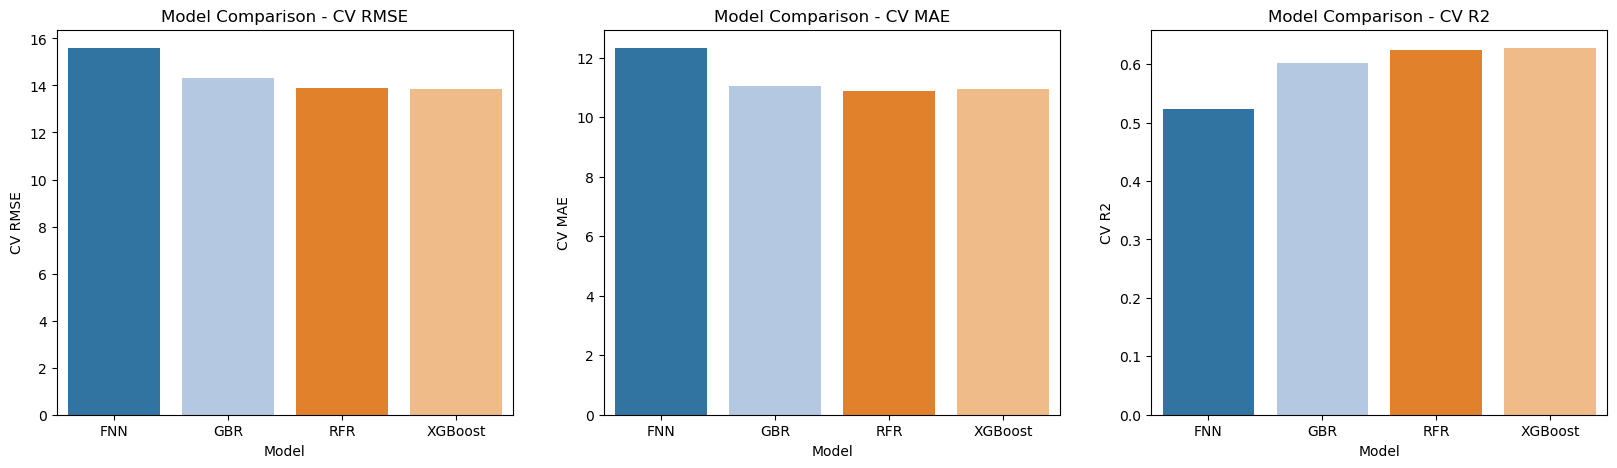

In [21]:
# Set figure size
plt.figure(figsize = (20,20))

# Create a subplot for each metric
metrics = ['CV RMSE', 'CV MAE', 'CV R2']
num_met = len(metrics)

# Create a subplot for each metric
fig, axes = plt.subplots(1, num_met, figsize = (20, 5), sharey = False)

for i, met in enumerate(metrics):
    sns.barplot(x = 'Model', y = met, data = metric_df, ax = axes[i], hue=metric_df.index, palette='tab20', legend = False)
    axes[i].set_title(f'Model Comparison - {met}')
    axes[i].set_ylabel(met)
    axes[i].set_xlabel('Model')
    
# Plot results
plt.show()

In [22]:
# Display metrics dataframe
metric_df

,Model,CV RMSE,CV MAE,CV R2
0,FNN,15.589991,12.325897,0.524224
1,GBR,14.296913,11.045706,0.601773
2,RFR,13.888954,10.870813,0.624492
3,XGBoost,13.837825,10.946327,0.627700


From the above results, we can see that the Random Forest and the XGBoost models have very similar metrics. Let's plot the predictions vs. true and the residuals to visualize the quality of results. Otherwise, we will defer to the slightly better model, the XGBoost Model.

In [23]:
# Create predictions for both models 
xgb_pred = xgb_model.predict(x_test)
rfr_pred = rf_model.predict(x_test)

In [24]:
# Reshape y_test to a numpy array for residual calculations
y_test_np = y_test.to_numpy().reshape(y_test.shape[0])

# Calculate residuals
rfr_resid = y_test_np - rfr_pred
xgb_resid = y_test_np - xgb_pred

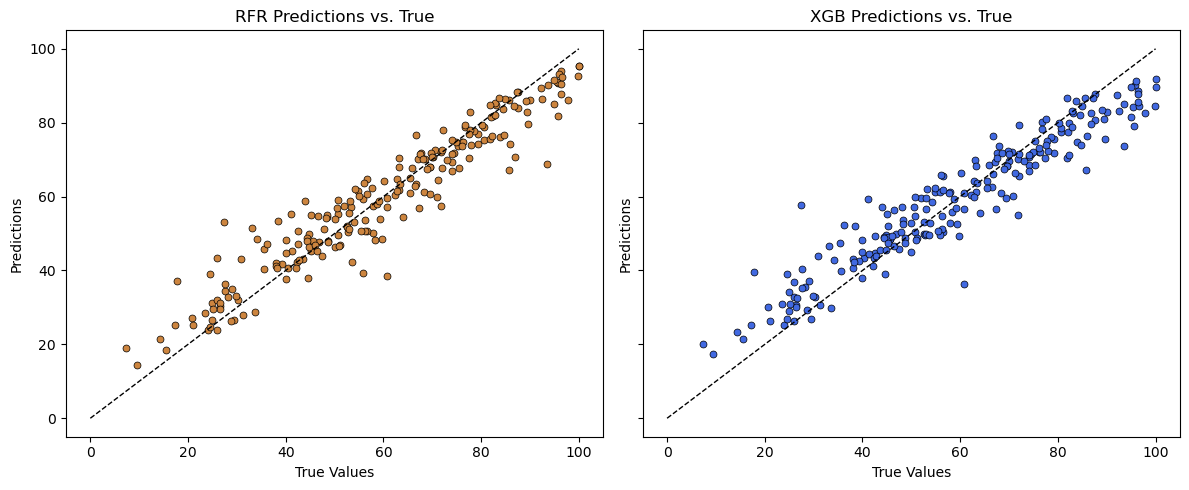

In [25]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# RFR Plot
axes[0].scatter(y_test, 
                rfr_pred, 
                color='peru', 
                s=25, 
                edgecolors='black', 
                linewidths=0.5)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predictions')
axes[0].set_title('RFR Predictions vs. True')
axes[0].plot([0, 100], [0, 100], 
             color='black', 
             linestyle='--', 
             linewidth=1)

# XGB Plot
axes[1].scatter(y_test, 
                xgb_pred, 
                color='royalblue', 
                s=25, 
                edgecolors='black', 
                linewidths=0.5)
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predictions')
axes[1].set_title('XGB Predictions vs. True')
axes[1].plot([0, 100], [0, 100], 
             color='black', 
             linestyle='--', 
             linewidth=1)

# Adjust layout and display
plt.tight_layout()
plt.show()

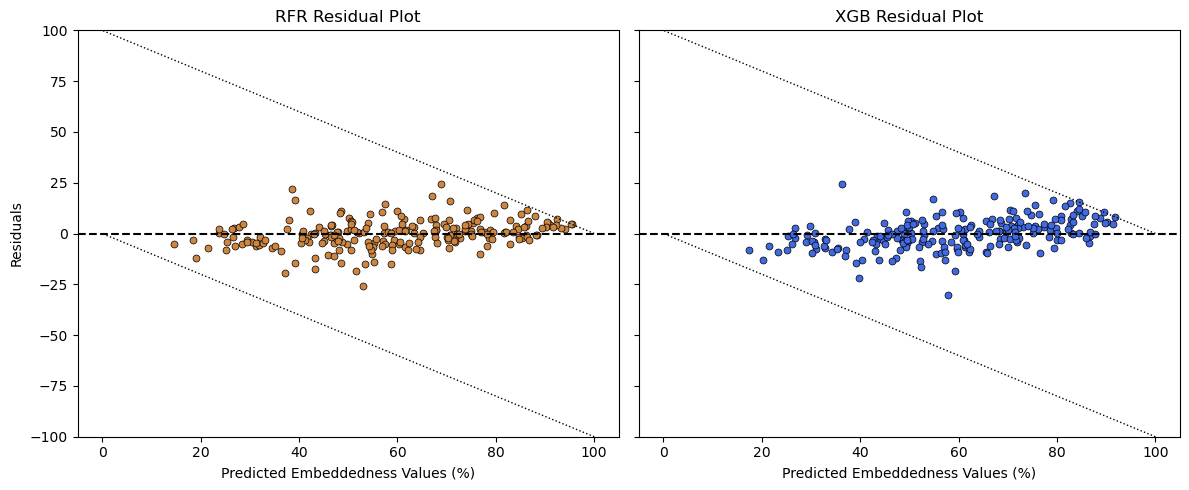

In [26]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# RFR Residual Plot
axes[0].scatter(rfr_pred, 
                rfr_resid, 
                color='peru', 
                s=25, 
                edgecolors='black', 
                linewidths=0.5)
axes[0].set_ylim(-100, 100)
axes[0].set_xlabel('Predicted Embeddedness Values (%)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('RFR Residual Plot')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].plot([100, 0], [0, 100], 
             color='black', 
             linestyle=':', 
             linewidth=1)
axes[0].plot([100, 0], [-100, 0], 
             color='black', 
             linestyle=':', 
             linewidth=1)

# XGB Residual Plot
axes[1].scatter(xgb_pred, 
                xgb_resid, 
                color='royalblue', 
                s=25, 
                edgecolors='black', 
                linewidths=0.5)
axes[1].set_ylim(-100, 100)
axes[1].set_xlabel('Predicted Embeddedness Values (%)')
axes[1].set_title('XGB Residual Plot')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].plot([100, 0], [0, 100], 
             color='black', 
             linestyle=':', 
             linewidth=1)
axes[1].plot([100, 0], [-100, 0], 
             color='black', 
             linestyle=':', 
             linewidth=1)

# Adjust layout and display
plt.tight_layout()
plt.show()

Based on the above plots, we see **little to no difference in model results visually.**
<br><br>Based on this information, we will move forward with the **XGBoost Model.**

## Step 4. Export Model & Results

In [27]:
# Export metric dataframe (model comparison visualization)
metric_path = os.path.join(BASE_DIR, "models", "model1_streamstats_va", "results", "vadeq_strmsts_models_metrics.xlsx")
metric_df.to_excel(metric_path)

In [28]:
# Save the trained XGBoost model and train_test_split for later use
mdl_path = os.path.join(BASE_DIR, "models", "model1_streamstats_va", "results", "trained_xgboost_model.pkl")
train_test_path = os.path.join(BASE_DIR, "data", "model_ready", "train_test_sets.pkl")

# Save sets/model
joblib.dump(xgb_model, mdl_path)
print('XGBoost model saved as trained_xgboost_model.pkl')
joblib.dump((x_train, x_test, y_train, y_test), train_test_path)
print('Training and testing sets saved as train_test_set.pkl')

XGBoost model saved as trained_xgboost_model.pkl
Training and testing sets saved as train_test_set.pkl
